<a href="https://colab.research.google.com/github/nimeshayasith/Computer_vision_Assignment/blob/main/4624_Question_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- STEP 1: RECONNECT GOOGLE DRIVE (Fixes Error 107) ---
from google.colab import drive
import os

# Force a remount to re-establish the broken connection
drive.mount('/content/drive', force_remount=True)

# Point back to your project folder
project_path = '/content/drive/MyDrive/CV_Assessment_01'
if os.path.exists(project_path):
    os.chdir(project_path)
    print("Drive reconnected and directory set successfully!")
else:
    print("Drive mounted, but folder not found. Please check your folder name.")

Mounted at /content/drive
Drive reconnected and directory set successfully!


Calculating Question 1 Differences (15x15 Average)...
Calculating Question 2 Differences (11x11 Median)...
Calculating Question 3 Differences (15x15 Gaussian)...


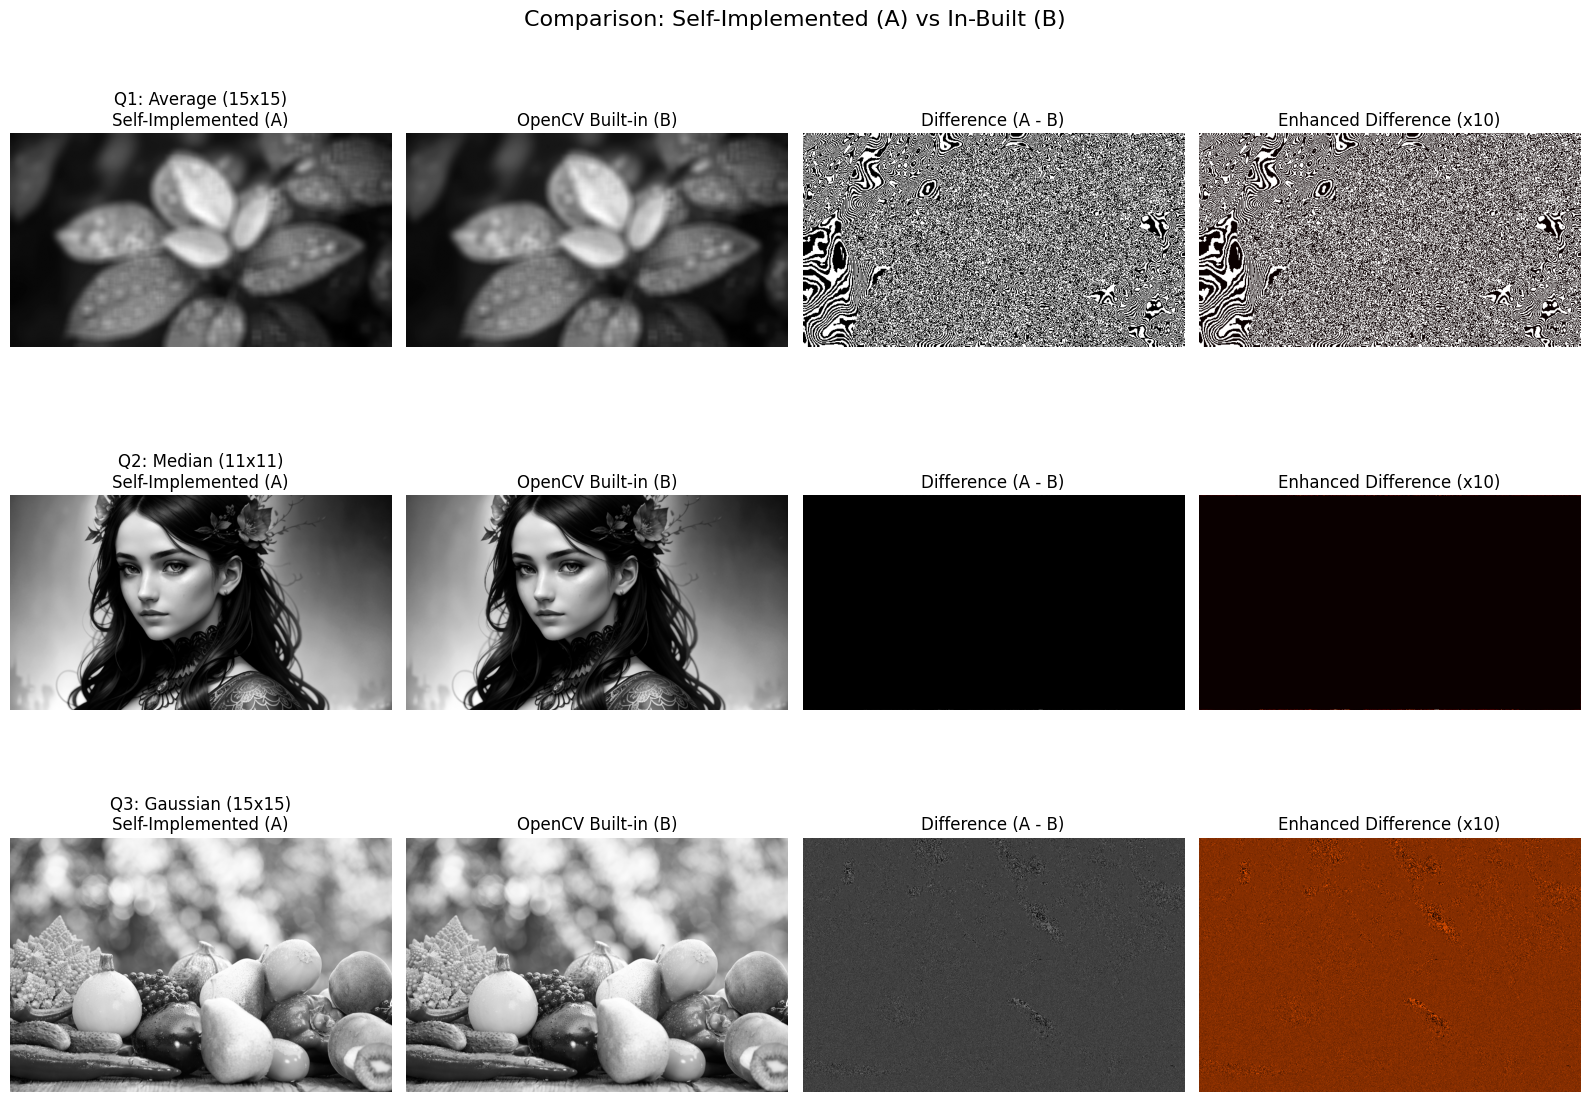

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# ==========================================
# RE-DEFINING HELPER FUNCTIONS FROM Q1, Q2, Q3
# (This ensures the script runs independently)
# ==========================================

def apply_custom_average_filter(image, kernel_size):
    kernel = np.ones((kernel_size, kernel_size), dtype=np.float32) / (kernel_size * kernel_size)
    pad = kernel_size // 2
    padded_img = np.pad(image, pad, mode='reflect')
    output_img = np.zeros_like(image, dtype=np.float32)
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            roi = padded_img[y:y+kernel_size, x:x+kernel_size]
            output_img[y, x] = np.sum(roi * kernel)
    return np.clip(output_img, 0, 255).astype(np.uint8)

def add_salt_and_pepper_noise(image, noise_ratio):
    noisy_img = np.copy(image)
    h, w = noisy_img.shape
    num_noise = int(h * w * noise_ratio)
    indices = random.sample(range(h * w), num_noise)
    for i, idx in enumerate(indices):
        y, x = idx // w, idx % w
        noisy_img[y, x] = 255 if i < num_noise / 2 else 0
    return noisy_img

def custom_median_filter(image, kernel_size):
    pad = kernel_size // 2
    padded_img = np.pad(image, pad, mode='reflect')
    output_img = np.zeros_like(image)
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            roi = padded_img[y:y+kernel_size, x:x+kernel_size]
            output_img[y, x] = np.median(roi)
    return output_img

def create_gaussian_kernel(size, sigma):
    kernel = np.zeros((size, size), dtype=np.float32)
    center = size // 2
    for y in range(size):
        for x in range(size):
            exponent = -((x - center)**2 + (y - center)**2) / (2 * sigma**2)
            kernel[y, x] = (1 / (2 * np.pi * sigma**2)) * np.exp(exponent)
    return kernel / np.sum(kernel)

def apply_custom_filter(image, kernel):
    k_size = kernel.shape[0]
    pad = k_size // 2
    padded_img = np.pad(image, pad, mode='reflect')
    output_img = np.zeros_like(image, dtype=np.float32)
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            roi = padded_img[y:y+k_size, x:x+k_size]
            output_img[y, x] = np.sum(roi * kernel)
    return np.clip(output_img, 0, 255).astype(np.uint8)


# ==========================================
# QUESTION 05: EXECUTION AND COMPARISON
# ==========================================

# --- 1. Load the Images ---
base_path = 'Dataset/IPCV_ ASSIGNMENT_01_DATABASE/Images_ For_Preliminary_Part/'
img_1 = cv2.imread(base_path + 'Image_1.jpg', cv2.IMREAD_GRAYSCALE)
img_2 = cv2.imread(base_path + 'Image_2.jpg', cv2.IMREAD_GRAYSCALE)
img_3 = cv2.imread(base_path + 'Image_3.jpg', cv2.IMREAD_GRAYSCALE)

if img_1 is None or img_2 is None or img_3 is None:
    print("Error: Could not load images. Please check the file paths.")
else:
    # Re-create the 20% noisy image for the Median filter comparison
    noisy_20 = add_salt_and_pepper_noise(img_2, 0.20)

    print("Calculating Question 1 Differences (15x15 Average)...")
    A_avg = apply_custom_average_filter(img_1, 15)
    B_avg = cv2.blur(img_1, (15, 15))
    diff_avg = cv2.absdiff(A_avg, B_avg)

    print("Calculating Question 2 Differences (11x11 Median)...")
    A_med = custom_median_filter(noisy_20, 11)
    B_med = cv2.medianBlur(noisy_20, 11)
    diff_med = cv2.absdiff(A_med, B_med)

    print("Calculating Question 3 Differences (15x15 Gaussian)...")
    fixed_sigma = 1.5
    gauss_kernel = create_gaussian_kernel(15, fixed_sigma)
    A_gauss = apply_custom_filter(img_3, gauss_kernel)
    B_gauss = cv2.GaussianBlur(img_3, (15, 15), fixed_sigma)
    diff_gauss = cv2.absdiff(A_gauss, B_gauss)

    # --- PLOTTING FOR REPORT ---
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    fig.suptitle("Comparison: Self-Implemented (A) vs In-Built (B)", fontsize=16)

    comparisons = [
        ("Q1: Average (15x15)", A_avg, B_avg, diff_avg),
        ("Q2: Median (11x11)", A_med, B_med, diff_med),
        ("Q3: Gaussian (15x15)", A_gauss, B_gauss, diff_gauss)
    ]

    for i, (title, A, B, diff) in enumerate(comparisons):
        axes[i, 0].imshow(A, cmap='gray')
        axes[i, 0].set_title(f"{title}\nSelf-Implemented (A)")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(B, cmap='gray')
        axes[i, 1].set_title("OpenCV Built-in (B)")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(diff, cmap='gray')
        axes[i, 2].set_title("Difference (A - B)")
        axes[i, 2].axis('off')

        # Multiply difference by 10 to make tiny, invisible pixel errors visible
        diff_enhanced = np.clip(diff.astype(np.int32) * 10, 0, 255).astype(np.uint8)
        axes[i, 3].imshow(diff_enhanced, cmap='hot')
        axes[i, 3].set_title("Enhanced Difference (x10)")
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()